## Данный проект посвящен исследованию предобученных моделей BERT для классификации нормативно-правовых документов в защиты информации

Анализ данных:
В качестве данных используем собранный нами датасет из документов ФСТЕК:

класс "0" - документы по ТЗИ, 

класс "1" - документы по ОБИ







In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
%matplotlib inline 

In [ ]:
import random
random.seed(0)
np.random.seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
df = pd.read_csv('/content/drive/MyDrive/final_dataset.csv')

In [49]:
df['class'] = df['class'].replace({1: 0, 0: 1})

In [53]:
#shuffle rows
df = df.sample(frac=1).reset_index(drop=True)

In [54]:
df.head()

,text,class
0,6 органами и российскими юридическими лицами....,1
1,2 (исполнительными устройствами) и производим...,1
2,44 Средний Сценарий реализации угроз безопасн...,0
3,81 FMT_MSA.1.1 ФБО должны осуществлять [назн...,0
4,"4. Федеральный орган исполнительной власти, ос...",0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


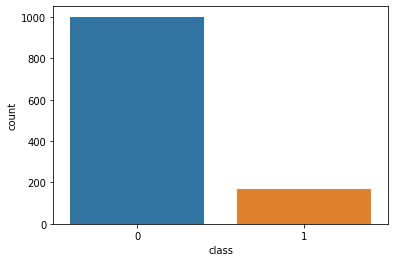

In [ ]:
# show distribution of classes
sns.countplot(df['class'])

In [ ]:
df_len = df['text'].apply(lambda x: len(x.split()))

In [ ]:
df_len.max()

622

In [ ]:
labels=set(df['class'])
id2label = {i:label for i,label in enumerate(labels) if label != None}
label2id = {label:i for i,label in enumerate(labels) if label != None}

Разобьем нашу выборку на train-sample и test-sample

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df['text']
y = df['class']

In [ ]:
import re
import string

def preprocessing_text(txt):
    txt = txt.lower()
    txt = re.sub(r'\n',' ', txt)
    txt = re.sub('[%s]' % re.escape(string.punctuation), '', txt)
    txt = re.sub(r'\s+', ' ', txt, flags=re.I)
    txt = re.sub(r'\W', ' ', txt)
    return txt

In [ ]:
X = X.apply(lambda x: preprocessing_text(x))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


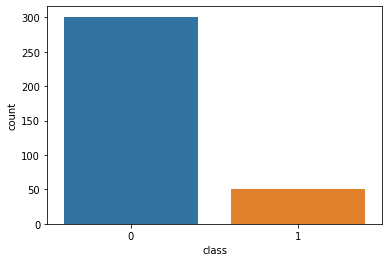

In [ ]:
sns.countplot(y_test)

Создаем модель

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 7.4 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 596 kB 57.0 MB/s 
     |████████████████████████████████| 880 kB 55.5 MB/s 
     |████████████████████████████████| 6.6 MB 52.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0085353056aeca0500dd337a55f800140734a1cfc8a239a3b26cf603c66347ce
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Tokenization

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
MODEL_NAME = 'DeepPavlov/rubert-base-cased-sentence'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def make_dataset(X, y):
    labels = [label2id[label] for label in y]
    texts = [tokenizer(text,padding='max_length', max_length = 100, truncation=True) for text in X]
    
    result = []
    for idx,(text,label) in enumerate(zip(texts,labels)):
        result.append({"input_ids" : text['input_ids'], 'attention_mask' : text['attention_mask'], "label" : label})
    return result

In [ ]:
test_dataset = make_dataset(X_test, y_test)

NameError: ignored

In [ ]:
train_dataset = make_dataset(X_train, y_train)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : recall_score(predictions, labels)}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, label2id=label2id,id2label=id2label,num_labels=len(labels))

loading configuration file https://huggingface.co/DeepPavlov/rubert-base-cased-sentence/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/c6da12aa84b0056f7fcf2ce40343ab08fd71045914c431fd8bf57709efc5abae.e8f15c5aad2f4653e46ceeba0bb32c02a629d106a902c964bce60523d290ac8f
Model config BertConfig {
  "_name_or_path": "DeepPavlov/rubert-base-cased-sentence",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": 0,
    "1": 1
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0": 0,
    "1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_nu

In [ ]:
args = TrainingArguments(
    "test-glue",
    evaluation_strategy = "steps",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.05,
    load_best_model_at_end=False,
    report_to=None,
    metric_for_best_model = 'accuracy'
    )
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )
trainer.train()

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 820
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. par

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=130, training_loss=0.122943298633282, metrics={'train_runtime': 70.9274, 'train_samples_per_second': 57.806, 'train_steps_per_second': 1.833, 'total_flos': 210694399800000.0, 'train_loss': 0.122943298633282, 'epoch': 5.0})

In [ ]:
class ClassifierLanguageModel():
	def __init__(self, model,tokenizer):
		self.model = model
		self.tokenizer = tokenizer

	def run(self, text):
		model_input = self.tokenizer.encode(text, return_tensors='pt').cuda()
		model_output = self.model.bert.config.id2label[self.model(model_input)['logits'].argmax().item()]
		return model_output

In [ ]:
classyfier = ClassifierLanguageModel(model,tokenizer)

In [ ]:
X1_test = X_test.apply(lambda x: ' '.join(x.split()[:100]))

In [ ]:
reference = []
predictions = []
for text,label in zip(X1_test, y_test):
  output = classyfier.run(text)
  predictions.append(output)
  reference.append(label)

In [ ]:
predictions[:10]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
reference[:10]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

Text(91.68, 0.5, 'true_value')

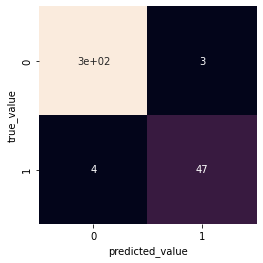

In [ ]:
baseline_conf_mat = confusion_matrix(reference, predictions)
sns.heatmap(baseline_conf_mat, square= True, annot=True, cbar=False)
plt.xlabel('predicted_value')
plt.ylabel('true_value')

In [ ]:
print('f1 score: ', f1_score(reference, predictions))
print('recall score: ', recall_score(reference, predictions))
print('precision score: ', precision_score(reference, predictions))

f1 score:  0.9306930693069307
recall score:  0.9215686274509803
precision score:  0.94


------------------------End-----------------------------------------------------

Let's try to use another type of rubert - distilled bert. It seems crazy but distilled rubert don't have good results(or I make some mistakes, hope to fit it)

In [ ]:
MODEL_NAME = 'cointegrated/rubert-tiny'

In [ ]:
tiny_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/457k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
tiny_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, label2id=label2id, id2label=id2label, num_labels=len(labels))

Downloading:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [ ]:
def make_dataset_tiny(X, y):
    labels = [label2id[label] for label in y]
    texts = [tiny_tokenizer(text,padding='max_length', max_length = 100, truncation=True) for text in X]
    
    result = []
    for idx,(text,label) in enumerate(zip(texts,labels)):
        result.append({"input_ids" : text['input_ids'], 'attention_mask' : text['attention_mask'], "label" : label})
    return result

In [ ]:
test_dataset = make_dataset_tiny(X_test, y_test)
train_dataset = make_dataset_tiny(X_train, y_train)

In [ ]:
args = TrainingArguments(
    "test-glue",
    evaluation_strategy = "steps",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.05,
    load_best_model_at_end=False,
    report_to=None,
    metric_for_best_model = 'accuracy'
    )
trainer = Trainer(
    tiny_model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tiny_tokenizer,
    compute_metrics=compute_metrics
    )
trainer.train()

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 820
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. par

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=130, training_loss=0.3125868577223558, metrics={'train_runtime': 4.2707, 'train_samples_per_second': 960.028, 'train_steps_per_second': 30.44, 'total_flos': 5905126680000.0, 'train_loss': 0.3125868577223558, 'epoch': 5.0})

In [ ]:
classyfier = ClassifierLanguageModel(tiny_model,tiny_tokenizer)

In [ ]:
reference = []
predictions = []
for text,label in zip(X1_test, y_test):
  output = classyfier.run(text)
  predictions.append(output)
  reference.append(label)

Text(91.68, 0.5, 'true_value')

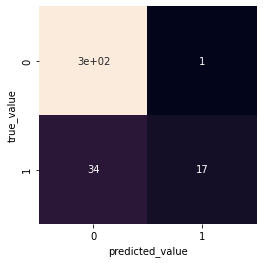

In [ ]:
baseline_conf_mat = confusion_matrix(reference, predictions)
sns.heatmap(baseline_conf_mat, square= True, annot=True, cbar=False)
plt.xlabel('predicted_value')
plt.ylabel('true_value')

In [ ]:
print('f1 score: ', f1_score(reference, predictions))
print('recall score: ', recall_score(reference, predictions))
print('precision score: ', precision_score(reference, predictions))

f1 score:  0.49275362318840576
recall score:  0.3333333333333333
precision score:  0.9444444444444444
